In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import detrend

In [7]:
births_df = pd.read_csv('Daily_Birth.csv')
births_df

,Date,Num_Births
0,1977-01-01,208
1,1977-01-02,241
2,1977-01-03,274
3,1977-01-04,256
4,1977-01-05,294
...,...,...
5108,1990-12-27,316
5109,1990-12-28,335
5110,1990-12-29,237
5111,1990-12-30,229


In [8]:
births_df['Date'] = pd.to_datetime(births_df['Date'])
births_df['Month'] = births_df['Date'].dt.month
births_df['Year'] = births_df['Date'].dt.year
births_df

,Date,Num_Births,Month,Year
0,1977-01-01,208,1,1977
1,1977-01-02,241,1,1977
2,1977-01-03,274,1,1977
3,1977-01-04,256,1,1977
4,1977-01-05,294,1,1977
...,...,...,...,...
5108,1990-12-27,316,12,1990
5109,1990-12-28,335,12,1990
5110,1990-12-29,237,12,1990
5111,1990-12-30,229,12,1990


In [12]:
#Aggregate DataFrame months -> Births per Month per Year
birth_month = births_df.groupby(['Year', 'Month'])['Num_Births'].sum().reset_index()

birth_month['Date'] = pd.to_datetime(birth_month['Year'].astype(str) + '-' + birth_month['Month'].astype(str), format='%Y-%m')

birth_ts = pd.Series(birth_month['Num_Births'].values, index=birth_month['Date'])
birth_ts.index.freq = 'MS'
birth_ts

Date
1977-01-01    8000
1977-02-01    7446
1977-03-01    8682
1977-04-01    8477
1977-05-01    8683
              ... 
1990-08-01    8531
1990-09-01    8480
1990-10-01    8156
1990-11-01    7455
1990-12-01    7673
Freq: MS, Length: 168, dtype: int64

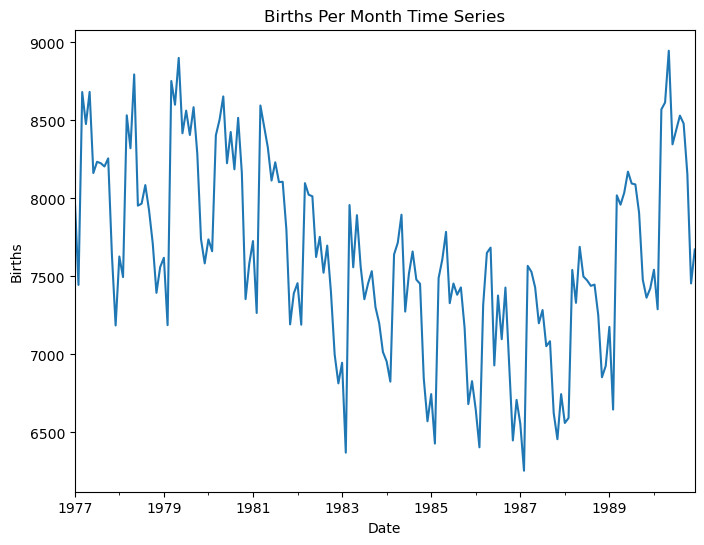

In [16]:
plt.figure(figsize=(8,6))
birth_ts.plot()
plt.title('Births Per Month Time Series')
plt.ylabel('Births')
plt.show()

In [17]:
birth_month = births_df.groupby(['Year'])['Num_Births'].mean().reset_index()

#birth_month['Date'] = pd.to_datetime(birth_month['Year'].astype(str) + '-' + birth_month['Month'].astype(str), format='%Y-%m')

birth_ts = pd.Series(birth_month['Num_Births'].values, index=birth_month['Year'])
birth_ts.index.freq = 'YS'
birth_ts

Year
1977    266.298630
1978    261.295890
1979    270.263014
1980    266.177596
1981    261.156164
1982    248.219178
1983    241.517808
1984    239.997268
1985    236.547945
1986    231.873973
1987    229.564384
1988    236.644809
1989    253.076712
1990    268.624658
dtype: float64

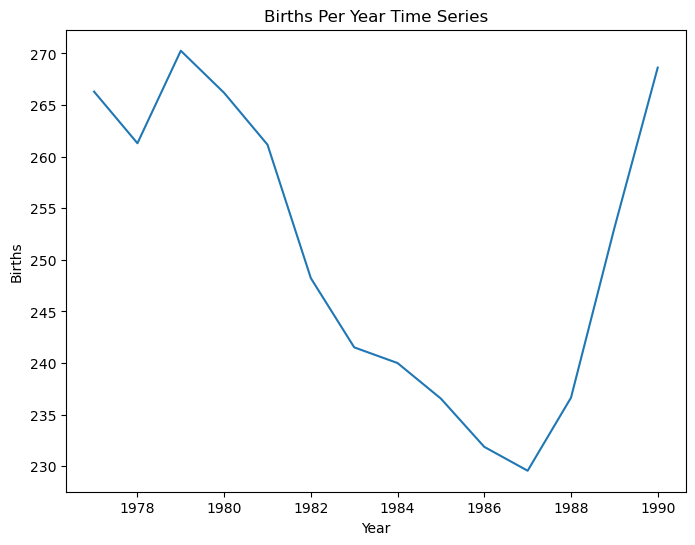

In [18]:
plt.figure(figsize=(8,6))
birth_ts.plot()
plt.title('Births Per Year Time Series')
plt.ylabel('Births')
plt.show()

In [19]:
air_df = pd.read_csv('PRSA_Changping.csv')
air_df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,28.0,47.0,4.0,14.0,300.0,NaN,11.7,1008.9,-13.3,0.0,NNE,1.3,Changping
35060,35061,2017,2,28,20,12.0,12.0,3.0,23.0,500.0,64.0,10.9,1009.0,-14.0,0.0,N,2.1,Changping
35061,35062,2017,2,28,21,7.0,23.0,5.0,17.0,500.0,68.0,9.5,1009.4,-13.0,0.0,N,1.5,Changping
35062,35063,2017,2,28,22,11.0,20.0,3.0,15.0,500.0,72.0,7.8,1009.6,-12.6,0.0,NW,1.4,Changping


In [20]:
air_df.isna().sum()

No            0
year          0
month         0
day           0
hour          0
PM2.5       774
PM10        582
SO2         628
NO2         667
CO         1521
O3          604
TEMP         53
PRES         50
DEWP         53
RAIN         51
wd          140
WSPM         43
station       0
dtype: int64

In [21]:
air_df = air_df.dropna()
air_df.isna().sum()

No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [22]:
air_df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35057,35058,2017,2,28,17,18.0,61.0,6.0,29.0,400.0,51.0,14.7,1007.4,-12.6,0.0,WNW,4.2,Changping
35060,35061,2017,2,28,20,12.0,12.0,3.0,23.0,500.0,64.0,10.9,1009.0,-14.0,0.0,N,2.1,Changping
35061,35062,2017,2,28,21,7.0,23.0,5.0,17.0,500.0,68.0,9.5,1009.4,-13.0,0.0,N,1.5,Changping
35062,35063,2017,2,28,22,11.0,20.0,3.0,15.0,500.0,72.0,7.8,1009.6,-12.6,0.0,NW,1.4,Changping


In [24]:
air_month = air_df.groupby(['year', 'month'])['NO2'].sum().reset_index()
air_month.head()

,year,month,NO2
0,2013,3,42031.0000
1,2013,4,24932.9939
2,2013,5,25057.0000
3,2013,6,10888.0000
4,2013,7,15497.0000


In [26]:
air_month['Date'] = pd.to_datetime(air_month['year'].astype(str) + '-' + air_month['month'].astype(str), format='%Y-%m')
air_month.head()

,year,month,NO2,Date
0,2013,3,42031.0000,2013-03-01
1,2013,4,24932.9939,2013-04-01
2,2013,5,25057.0000,2013-05-01
3,2013,6,10888.0000,2013-06-01
4,2013,7,15497.0000,2013-07-01


In [30]:
air_ts = pd.Series(air_month['NO2'].values, index=air_month['Date'])
air_ts.head()

Date
2013-03-01    42031.0000
2013-04-01    24932.9939
2013-05-01    25057.0000
2013-06-01    10888.0000
2013-07-01    15497.0000
dtype: float64

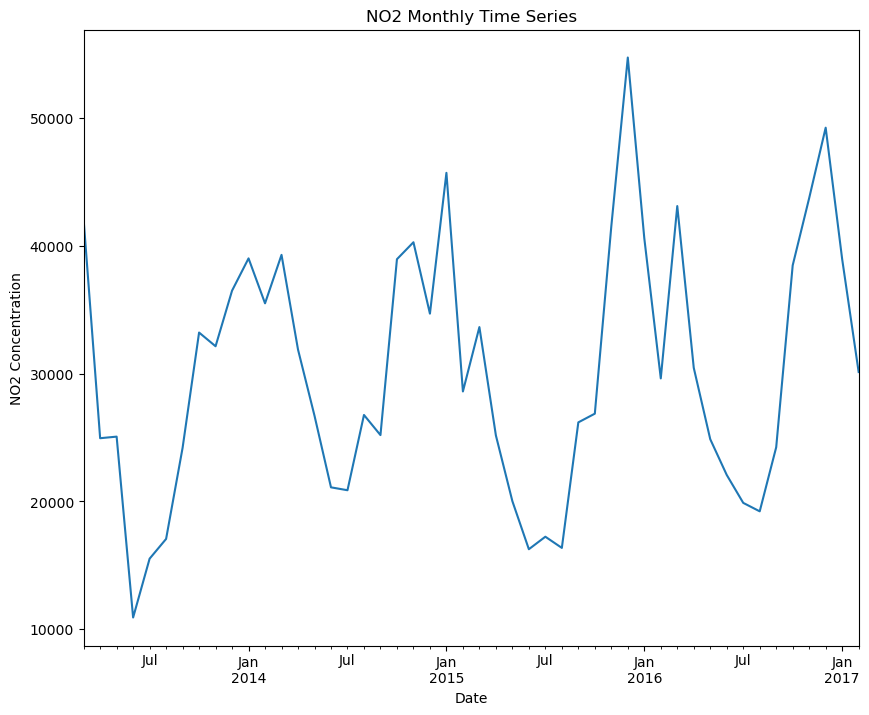

In [32]:
plt.figure(figsize=(10,8))
air_ts.plot()
plt.title('NO2 Monthly Time Series')
plt.ylabel('NO2 Concentration')
plt.show()

In [33]:
sm.stats.acorr_ljungbox(air_ts, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,90.283344,4.705886e-15


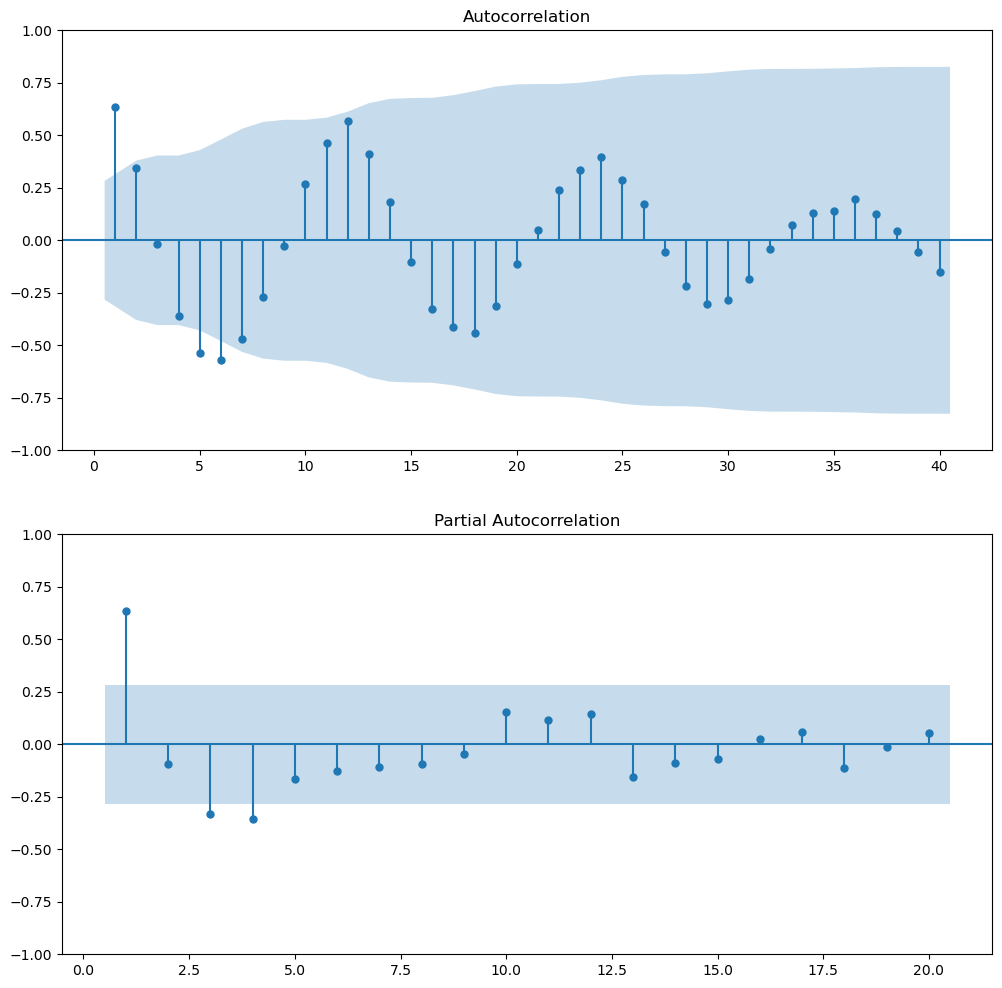

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12)) 
plot_acf(air_ts, ax1, lags=40, zero=False)
plot_pacf(air_ts, ax2, lags=20, zero=False)
plt.show()

In [36]:
ad_fuller = adfuller(air_ts, regression='c')
ad_fuller

(-4.887437010428412,
 3.689214119997695e-05,
 5,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 760.6441408190611)